In [ ]:
!pip install torch==1.11.0  # version recommended by source
!pip install git+https://github.com/gretelai/gretel-synthetics.git

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from skimage.util.shape import view_as_windows
import time

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [8]:
slice0 = pd.read_csv('../data/kagglePump/slice0.csv') 
slice1 = pd.read_csv('../data/kagglePump/slice1.csv') 
slice2 = pd.read_csv('../data/kagglePump/slice2.csv')
slice3 = pd.read_csv('../data/kagglePump/slice3.csv') 
slice4 = pd.read_csv('../data/kagglePump/slice4.csv')
slice5 = pd.read_csv('../data/kagglePump/slice5.csv') 
slice6 = pd.read_csv('../data/kagglePump/slice6.csv') 


print(slice0.shape, slice1.shape, slice2.shape, slice3.shape, slice4.shape, slice5.shape, slice6.shape)

(3601, 6) (3601, 6) (3601, 6) (3601, 6) (3601, 6) (3601, 6) (3601, 6)


In [27]:
# prep for plotting
slices_list = [slice0, slice1, slice2, slice3, slice4, slice5, slice6]
sensor_cols = ['sensor_25', 'sensor_11', 'sensor_36', 'sensor_34']

# cast timestamps to be type datetime
for sl in slices_list:
    sl['timestamp']= pd.to_datetime(sl['timestamp'])

# remove 1st row to be same as data used in prev. nb
for i in range(len(slices_list)):
    slices_list[i] = slices_list[i].iloc[1: , :]
    print(len(slices_list[i]))
    
# create df of our dfs
all_slices = pd.concat(slices_list)

# create np array of that df.
all_slices_np = all_slices.to_numpy()

3600
3600
3600
3600
3600
3600
3600


In [28]:
all_slices

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
1,2018-04-10 09:56:00,723.9152,41.01725,256.5261,163.6026,0.0
2,2018-04-10 09:57:00,723.8909,41.21749,256.9553,166.5880,0.0
3,2018-04-10 09:58:00,717.3254,41.41220,261.0644,164.9973,0.0
4,2018-04-10 09:59:00,721.9371,41.50766,262.5026,162.6964,0.0
5,2018-04-10 10:00:00,727.7538,41.48899,263.6401,164.2985,0.0
...,...,...,...,...,...,...
3596,2018-07-25 13:56:00,740.9833,49.88500,804.9069,342.3690,0.0
3597,2018-07-25 13:57:00,738.9200,49.96759,804.2908,345.2228,0.0
3598,2018-07-25 13:58:00,743.5366,49.75908,796.3863,344.4498,0.0
3599,2018-07-25 13:59:00,743.1452,49.73039,796.2476,339.3840,0.0


In [20]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=720, # hard coded from prev shape
    sample_len=20, # trying a larger sample_len
    batch_size=min(1000, 300),
    apply_feature_scaling=True, 
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

model = DGAN(config)

model = model.load("../models/dgan_model_2.pt", map_location=torch.device('cpu'))

In [21]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(1000)

In [22]:
def plot_12hr_slice(slice, ind):
    
    for i, c in enumerate(sensor_cols):
        plt.plot(slice[:,i], label=c)
    ax = plt.gca()
    ax.title.set_text("Slice" +str(ind))
    plt.legend(prop={'size': 7})

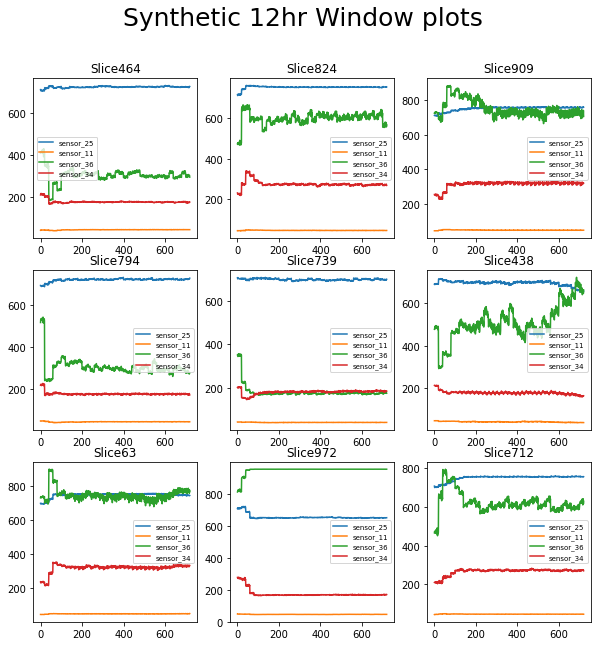

In [39]:
# plot random synthetic windows

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Synthetic 12hr Window plots", fontsize=25, fontweight='roman')

for i in range(9):
    figure.add_subplot(3, 3, i+1)
    index = np.random.choice(1000)
    sl = synthetic_features[index]
    plot_12hr_slice(sl, index)
    
plt.show()

In [24]:
# Compare (non-temporal) correlations between the 4 sensors
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=sensor_cols)

print("Correlation in real data:")
print(all_slices.drop(columns=["timestamp","machine_status"]).corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

# Correlations between sensor variables are worse now 
# Makes sense as we are using 6 different slices rather than 1.
# will have to discuss if this is acceptable.

Correlation in real data:
           sensor_25  sensor_11  sensor_36  sensor_34
sensor_25   1.000000   0.545216   0.468289   0.504015
sensor_11   0.545216   1.000000   0.426311   0.414570
sensor_36   0.468289   0.426311   1.000000   0.655227
sensor_34   0.504015   0.414570   0.655227   1.000000

Correlation in synthetic data:
           sensor_25  sensor_11  sensor_36  sensor_34
sensor_25   1.000000   0.208979   0.064547   0.693662
sensor_11   0.208979   1.000000   0.373766   0.651838
sensor_36   0.064547   0.373766   1.000000   0.536476
sensor_34   0.693662   0.651838   0.536476   1.000000


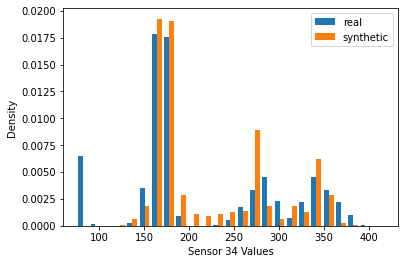

In [30]:
# Compare distribution of sensor_34 values
plt.hist([all_slices_np[:,4].flatten(), synthetic_features[:,:,3].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 34 Values")
plt.ylabel("Density")
plt.show()

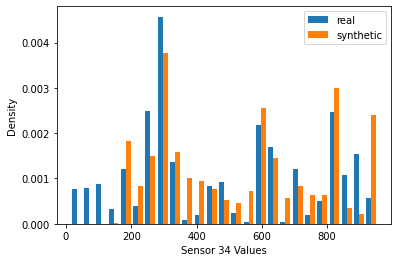

In [32]:
# Compare distribution of sensor_36 values
plt.hist([all_slices_np[:,3].flatten(), synthetic_features[:,:,2].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 36 Values")
plt.ylabel("Density")
plt.show()

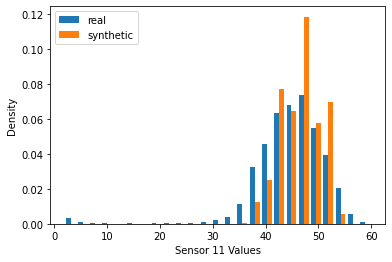

In [36]:
# Compare distribution of sensor_11 values
plt.hist([all_slices_np[:,2].flatten(), synthetic_features[:,:,1].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 11 Values")
plt.ylabel("Density")
plt.show()

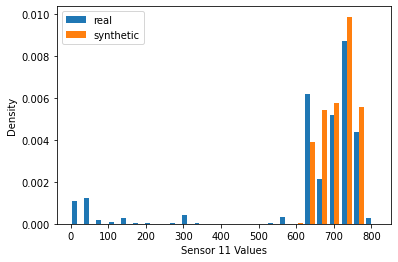

In [40]:
# Compare distribution of sensor_25 values
plt.hist([all_slices_np[:,1].flatten(), synthetic_features[:,:,0].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Sensor 11 Values")
plt.ylabel("Density")
plt.show()